# FLAM RESEARCH ASSIGNMENT

DE start: [ 5.16317529e-01 -5.00000000e-02  5.50136077e+01]
Best params (theta [rad], M, X) = [4.90610464e-01 2.14413236e-02 5.49005240e+01]
Best params (theta [deg]) =  28.10990898228646
L1 total: 37865.11196929344
L1 mean per point: 25.243407979528957


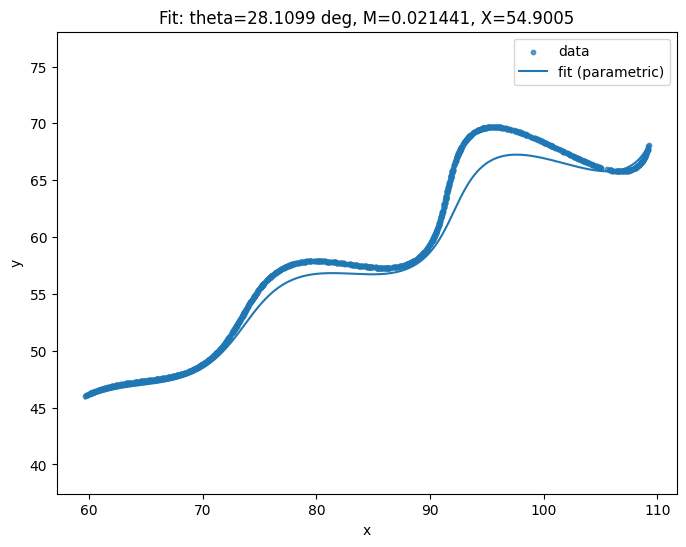


Final parameterized expression:

(t*\cos(0.490610) - e^{0.021441|t|} * \sin(0.3 t) \sin(0.490610) + 54.900524, 42 + t*\sin(0.490610) + e^{0.021441|t|} * \sin(0.3 t) \cos(0.490610))


In [5]:
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution, minimize
import matplotlib.pyplot as plt

CSV_PATH = "xy_data.csv"

theta_bounds = (0.0, np.deg2rad(50.0))  # radians
M_bounds     = (-0.05, 0.05)
X_bounds     = (0.0, 100.0)
bounds = [theta_bounds, M_bounds, X_bounds]

# load data
df = pd.read_csv(CSV_PATH)
cols = list(df.columns)

x_data = df[df.columns[0]].values.astype(float)
y_data = df[df.columns[1]].values.astype(float)
N = len(x_data)
t = np.linspace(6.0, 60.0, N)  # assume uniform ordered sampling

def model(params, tvals):
    theta, M, X = params
    expo = np.exp(M * np.abs(tvals))
    s03t = np.sin(0.3 * tvals)
    x = tvals * np.cos(theta) - expo * s03t * np.sin(theta) + X
    y = 42.0 + tvals * np.sin(theta) + expo * s03t * np.cos(theta)
    return x, y

def residuals_l2(params):
    x_pred, y_pred = model(params, t)
    res = np.concatenate([(x_pred - x_data), (y_pred - y_data)])
    return res

def objective_l1(params):
    x_pred, y_pred = model(params, t)
    res = np.abs(x_pred - x_data) + np.abs(y_pred - y_data)
    return np.sum(res)

def obj_l2_scalar(params):
    r = residuals_l2(params)
    return np.sum(r**2)

result_de = differential_evolution(obj_l2_scalar, bounds=bounds, maxiter=200, polish=True)
start = result_de.x
print("DE start:", start)

res_local = minimize(objective_l1, start, method='Powell', bounds=bounds, options={'maxiter':10000, 'xtol':1e-10})
params_best = res_local.x
print("Best params (theta [rad], M, X) =", params_best)
print("Best params (theta [deg]) = ", np.rad2deg(params_best[0]))

x_fit, y_fit = model(params_best, t)
l1_sum = np.sum(np.abs(x_fit - x_data) + np.abs(y_fit - y_data))
l1_mean = l1_sum / len(t)
print("L1 total:", l1_sum)
print("L1 mean per point:", l1_mean)

plt.figure(figsize=(8,6))
plt.scatter(x_data, y_data, s=10, label='data', alpha=0.7)
plt.plot(x_fit, y_fit, '-', linewidth=1.5, label='fit (parametric)')
plt.axis('equal')
plt.legend()
plt.title(f"Fit: theta={np.rad2deg(params_best[0]):.4f} deg, M={params_best[1]:.6f}, X={params_best[2]:.4f}")
plt.xlabel('x'); plt.ylabel('y')
plt.show()

theta_val, M_val, X_val = params_best
print("\nFinal parameterized expression:\n")
print(rf"(t*\cos({theta_val:.6f}) - e^{{{M_val:.6f}|t|}} * \sin(0.3 t) \sin({theta_val:.6f}) + {X_val:.6f}, 42 + t*\sin({theta_val:.6f}) + e^{{{M_val:.6f}|t|}} * \sin(0.3 t) \cos({theta_val:.6f}))")
